In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns  
from gensim.models import FastText
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
from scipy.stats import loguniform

In [19]:
data = pd.read_csv("Data/GamesDataClean.csv", usecols=["content", "score", "game_name"])
data = data.dropna()
subset = (
    data.groupby("game_name", group_keys=False)
        .apply(lambda x: x.sample(n=min(50, len(x)), random_state=42))
        .reset_index(drop=True)
)
subset

C:\Users\Austin\AppData\Local\Temp\ipykernel_16312\3173297405.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(50, len(x)), random_state=42))


,game_name,content,score
0,8 Ball Pool,game awesome well design smooth good game give...,3
1,8 Ball Pool,keep scroll find opponent click play opponent ...,1
2,8 Ball Pool,get old someone come kind hack win shot turn o...,4
3,8 Ball Pool,like game everytime open box game restart fix ...,5
4,8 Ball Pool,bad game hit ball hard game freeze get kick ma...,4
...,...,...,...
995,Shadow Fight 2,game like friend show game install game work p...,1
996,Shadow Fight 2,great game play year issue game enter underwor...,4
997,Shadow Fight 2,pay win pay stop torture download mod version ...,1
998,Shadow Fight 2,game really go good untill bot appear underwor...,3


In [20]:
X = subset["content"].values
y = subset["score"].astype(int).values

In [21]:
tfidfContent = X

FastTextContent = []
for text in X:
    FastTextContent.append(text.split())

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_FT, X_test_FT, y_train_FT, y_test_FT = train_test_split(FastTextContent, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    stop_words="english"
)
X_train_TF = tfidf.fit_transform(X_train_TF)
X_test_TF = tfidf.transform(X_test_TF)

In [24]:
model_ft = FastText(
    sentences=X_train_FT,
    vector_size=300,
    window=5,
    min_count=5,
    sg=1,
    workers=os.cpu_count(),
    epochs=10
)
ft = model_ft.wv

def avg_vector(tokens, model):
    words = [w for w in tokens if w in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[w] for w in words], axis=0)

X_train_avg = np.array([avg_vector(t, model_ft) for t in X_train_FT])
X_test_avg = np.array([avg_vector(t, model_ft) for t in X_test_FT])

In [25]:
# --- Parameters ---
max_len = 200          
embed_dim = model_ft.vector_size 

# --- Word to vector sequence ---
def tokens_to_vectors(tokens, model, max_len):
    seq = []
    for w in tokens:
        if w in model.wv:
            seq.append(model.wv[w])
        else:
            seq.append(np.zeros(embed_dim))  # handle OOV
        if len(seq) >= max_len:
            break
    # pad to max_len
    if len(seq) < max_len:
        seq += [np.zeros(embed_dim)] * (max_len - len(seq))
    return np.array(seq)

X_train_seq = np.array([tokens_to_vectors(t, model_ft, max_len) for t in X_train_FT])
X_test_seq  = np.array([tokens_to_vectors(t, model_ft, max_len) for t in X_test_FT])

print("Train shape:", X_train_seq.shape)
print("Test shape :", X_test_seq.shape)

Train shape: (800, 200, 300)
Test shape : (200, 200, 300)


In [26]:
if y_train.min() == 1:
    y_train = y_train - 1
    y_test  = y_test  - 1
    y_train_FT = y_train_FT - 1
    y_test_FT  = y_test_FT  - 1

## Logistic Regression

In [ ]:
# === Fine-tuning gabungan: TF-IDF + Logistic Regression ===
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from scipy.stats import loguniform
import joblib

# ---------------------------------------------------------
# 0) Data mentah (ganti variabel ini dengan punyamu)
# ---------------------------------------------------------
# X_train_raw: list/Series teks review (train)
# X_test_raw : list/Series teks review (test)
# y_train, y_test: label (int 0..4 atau 1..5 — konsisten!)
# ---------------------------------------------------------

# 1) Pipeline: TF-IDF -> LR
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(
        max_iter=3000, multi_class="multinomial", solver="lbfgs", n_jobs=-1
    ))
])

# 2) Ruang hyperparameter (cukup lebar tapi tetap efisien)
param_dist = {
    # TF-IDF
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 3, 5, 10],
    "tfidf__max_df": [0.85, 0.9, 0.95],
    "tfidf__max_features": [5000, 10000, 20000, None],
    # Logistic Regression
    "clf__C": loguniform(1e-3, 1e2),
    "clf__class_weight": [None, "balanced"],
    "clf__solver": ["lbfgs", "saga"],
}

# 3) CV + pencarian
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=100,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

# 4) Fit di TRAIN (pakai TEKS mentah)
search.fit(X_train, y_train)

best_model = search.best_estimator_
print("\nBest params:", search.best_params_)
print("CV best macro-F1: %.4f" % search.best_score_)

# 5) Evaluasi di TEST
pred = best_model.predict(X_test)
print("\n=== TF-IDF + LR (Fine-tuned) ===")
print("Accuracy :", accuracy_score(y_test, pred))
print("Macro-F1 :", f1_score(y_test, pred, average="macro"))
print("Weighted-F1 :", f1_score(y_test, pred, average="weighted"))
print("\nClassification report:\n", classification_report(y_test, pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits

Best params: {'clf__C': 0.9665728330249298, 'clf__class_weight': 'balanced', 'clf__solver': 'lbfgs', 'tfidf__max_df': 0.9, 'tfidf__max_features': 10000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
CV best macro-F1: 0.3818

=== TF-IDF + LR (Fine-tuned) ===
Accuracy : 0.47
Macro-F1 : 0.3379580478651686
Weighted-F1 : 0.4877444245013905

Classification report:
               precision    recall  f1-score   support

           0     0.4921    0.5741    0.5299        54
           1     0.0500    0.0714    0.0588        14
           2     0.1364    0.1875    0.1579        16
           3     0.2667    0.2424    0.2540        33
           4     0.7846    0.6145    0.6892        83

    accuracy                         0.4700       200
   macro avg     0.3459    0.3380    0.3380       200
weighted avg     0.5169    0.4700    0.4877       200

Confusion matrix:
 [[31  8  8  6  1]
 [ 5  1  5  2  1]
 [ 5  4  3  2  2]
 [10  

c:\Users\Austin\anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe_ft_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(max_iter=3000, multi_class="multinomial", solver="lbfgs", n_jobs=-1))
])

param_dist_ft = {
    "clf__C": loguniform(1e-3, 1e+2),
    "clf__class_weight": [None, "balanced"],
    # "clf__solver": ["lbfgs", "saga"],
}

search_ft = RandomizedSearchCV(
    pipe_ft_lr,
    param_distributions=param_dist_ft,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

# Gunakan matriks FastText-avg yang sudah kamu bangun: X_train_avg / X_test_avg
search_ft.fit(X_train_avg, y_train_FT)
best_ft = search_ft.best_estimator_
pred_FT_LR_ft = best_ft.predict(X_test_avg)

print("\nFastText-avg + LR (finetuned) best params:", search_ft.best_params_)
print("Accuracy :", accuracy_score(y_test_FT, pred_FT_LR_ft))
print("Macro-F1 :", f1_score(y_test_FT, pred_FT_LR_ft, average="macro"))
print("\nClassification report:\n", classification_report(y_test_FT, pred_FT_LR_ft, digits=4))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Austin\anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



FastText-avg + LR (finetuned) best params: {'clf__C': 73.92266140516048, 'clf__class_weight': None}
Accuracy : 0.445
Macro-F1 : 0.3308002597770465

Classification report:
               precision    recall  f1-score   support

           0     0.4717    0.4630    0.4673        54
           1     0.2000    0.2857    0.2353        14
           2     0.0769    0.0625    0.0690        16
           3     0.2368    0.2727    0.2535        33
           4     0.6579    0.6024    0.6289        83

    accuracy                         0.4450       200
   macro avg     0.3287    0.3373    0.3308       200
weighted avg     0.4596    0.4450    0.4510       200



## XGBoost Model

In [29]:
xgb_tfidf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train_TF)),
    eval_metric="mlogloss",
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_tfidf.fit(X_train_TF, y_train_TF)
pred_TF_XGB = xgb_tfidf.predict(X_test_TF)

xgb_ft = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train_FT)),
    eval_metric="mlogloss",
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_ft.fit(X_train_avg, y_train_FT)
pred_FT_XGB = xgb_ft.predict(X_test_avg)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4], got [1 2 3 4 5]

## Bidirectional LSTM

In [ ]:
inp = layers.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))  # (max_len, embed_dim)

x = layers.SpatialDropout1D(0.3)(inp)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(5, activation="softmax")(x)

FT_model = models.Model(inp, out)
FT_model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
FT_model.summary()

cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 300)]        0         
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 256)         439296    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                           

In [ ]:
ytr = np.asarray(y_train_FT)
yte = np.asarray(y_test_FT)

history = FT_model.fit(
    X_train_seq, ytr,
    validation_split=0.1,
    epochs=100,
    batch_size=256,
    callbacks=cbs,
    verbose=0
)

proba = FT_model.predict(X_test_seq, batch_size=256, verbose=0)
pred_FT_LSTM  = proba.argmax(axis=1)

In [ ]:
results = {
    "Model": [
        "TF-IDF + Logistic Regression",
        "TF-IDF + XGBoost",
        "FastText (avg) + Logistic Regression",
        "FastText (avg) + XGBoost",
        "FastText (seq) + BiLSTM"
    ],
    "Accuracy": [
        accuracy_score(y_test_TF, pred_TF_LR),
        accuracy_score(y_test_TF, pred_TF_XGB),
        accuracy_score(y_test_FT, pred_FT_LR),
        accuracy_score(y_test_FT, pred_FT_XGB),
        accuracy_score(y_test_FT, pred_FT_LSTM)
    ],
    "Macro-F1": [
        f1_score(y_test_TF, pred_TF_LR, average="macro"),
        f1_score(y_test_TF, pred_TF_XGB, average="macro"),
        f1_score(y_test_FT, pred_FT_LR, average="macro"),
        f1_score(y_test_FT, pred_FT_XGB, average="macro"),
        f1_score(y_test_FT, pred_FT_LSTM, average="macro")
    ],
    "Weighted-F1": [
        f1_score(y_test_TF, pred_TF_LR, average="weighted"),
        f1_score(y_test_TF, pred_TF_XGB, average="weighted"),
        f1_score(y_test_FT, pred_FT_LR, average="weighted"),
        f1_score(y_test_FT, pred_FT_XGB, average="weighted"),
        f1_score(y_test_FT, pred_FT_LSTM, average="weighted")
    ]
}

df_results = pd.DataFrame(results)
df_results.round(4)

,Model,Accuracy,Macro-F1,Weighted-F1
0,TF-IDF + Logistic Regression,0.5270,0.4085,0.5428
1,TF-IDF + XGBoost,0.5725,0.3342,0.5050
2,FastText (avg) + Logistic Regression,0.5020,0.4097,0.5303
3,FastText (avg) + XGBoost,0.5875,0.3514,0.5249
4,FastText (seq) + BiLSTM,0.6055,0.3530,0.5392


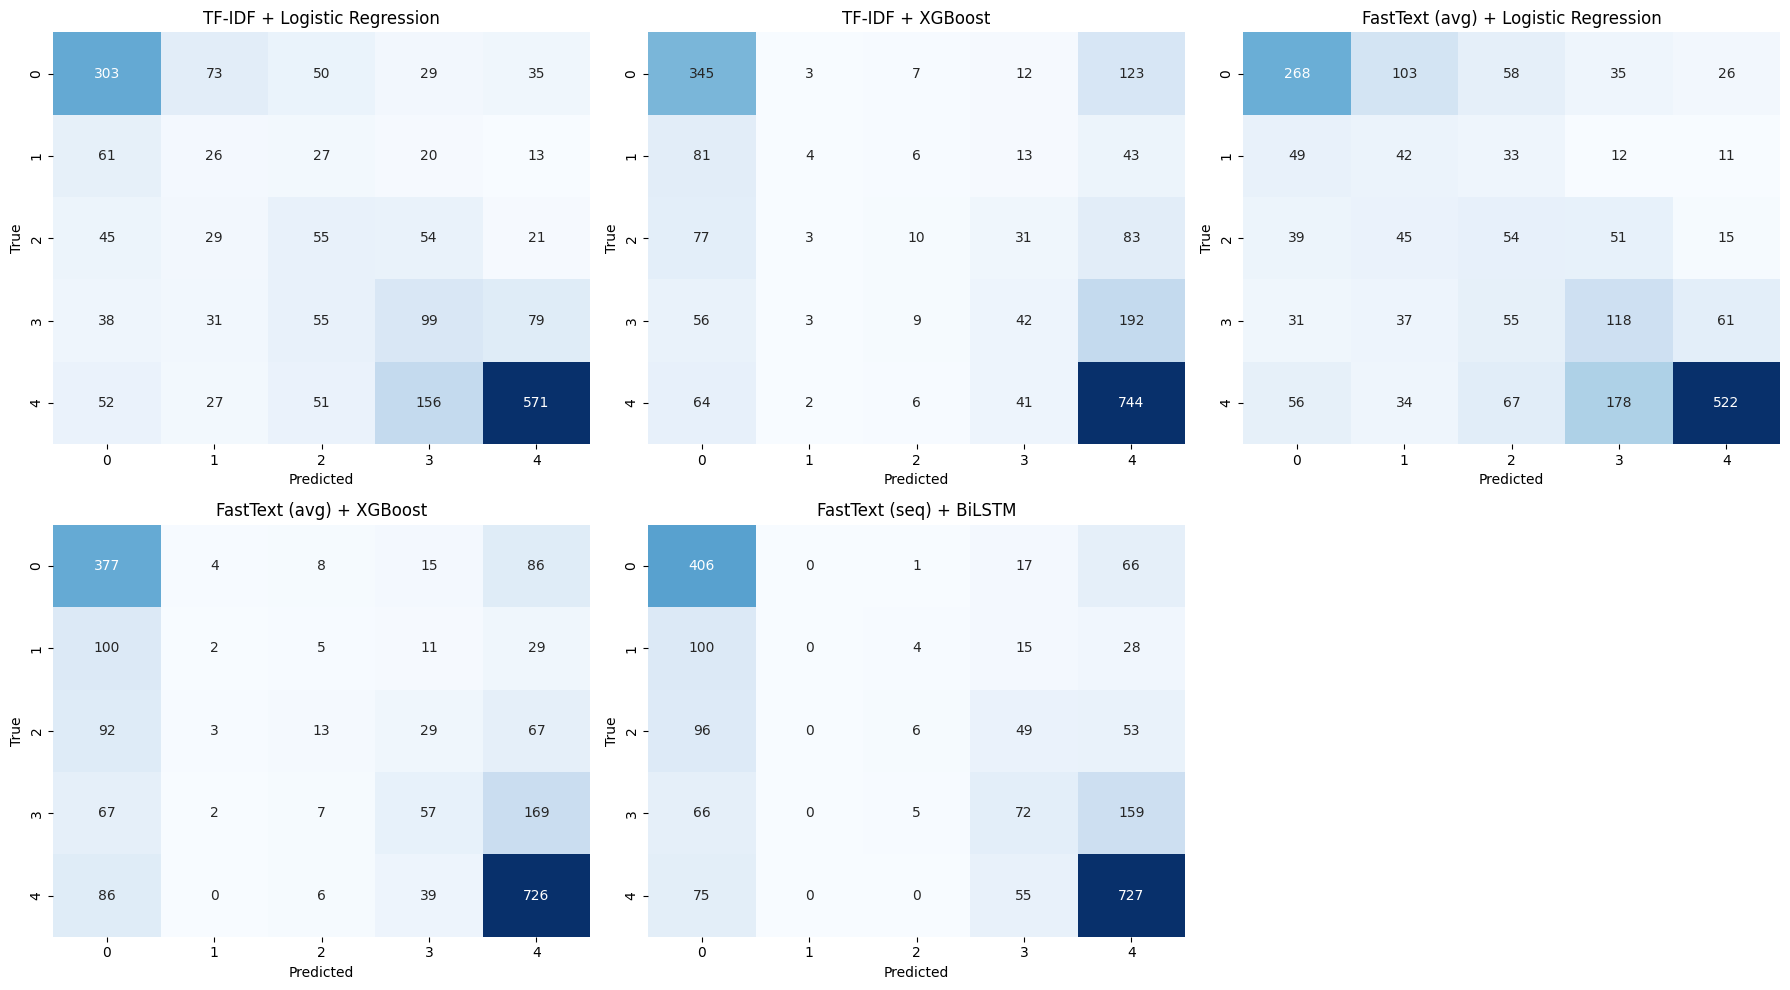

In [ ]:
# --- Confusion Matrices ---
preds = [
    (pred_TF_LR, y_test_TF, "TF-IDF + Logistic Regression"),
    (pred_TF_XGB, y_test_TF, "TF-IDF + XGBoost"),
    (pred_FT_LR, y_test_FT, "FastText (avg) + Logistic Regression"),
    (pred_FT_XGB, y_test_FT, "FastText (avg) + XGBoost"),
    (pred_FT_LSTM, y_test_FT, "FastText (seq) + BiLSTM"),
]

# Determine number of classes automatically
num_classes = len(np.unique(y_test_TF))
class_labels = [str(i) for i in range(num_classes)]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (pred, y_true, title) in enumerate(preds):
    if i >= len(axes):  # safety check if fewer than 6 subplots
        break
    cm = confusion_matrix(y_true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# Hide extra subplot if any
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()